In [1]:
%load_ext autoreload
%autoreload 2
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

from standes.analysis.recorders import get_recorders, get_recorder 

In [5]:
# load results
ROOT = Path("E:/01_model_verification_analyses/damping_model")
model_folders = {"modal_12": "3s_cbf_dc2_41_modal_12"}
record_folders = {"2.0" : "nltha_120621_sf2000",}
                  #"3.46": "nltha_120621_sf3460"}

# load results
model_results = {}
for model_tag, model_folder in model_folders.items():
    record_results = {}
    for record_tag, record_folder in record_folders.items():
        results_folder = ROOT / model_folder / record_folder
        temp = {}
        with open(results_folder / "recorders.pickle", "rb") as file:
            temp["recorders"] = pickle.load(file)
        with open(results_folder / "collapserecorders.pickle", "rb") as file:
            temp["collapserecorders"] = pickle.load(file)
        with open(results_folder / "timearray.pickle", "rb") as file:
            temp["time"] = np.array(pickle.load(file))
        with open(results_folder / "collapse.json", "r") as file:
            data = json.load(file)
        temp = temp | data
        temp["nodal_masses"] = {int(k):v for k, v in temp["nodal_masses"].items()}
        
        record_results[record_tag] = temp
    model_results[model_tag] = record_results

In [19]:
# Extract the node accelerations and calculate the nodal inertial force
model_responses = {}
for model_tag, mr in model_results.items():
    record_responses = {}
    for record_tag, rr in mr.items():
        record_response = {}

        # storey inertial force history
        fi_responses = {}
        acc_responses = {}
        # acceleration history
        for level_jj in range(2,5):
            acc = {}
            fi = {}
            storey_inertial_force = np.array(0.0)
            sum_acc = np.array(0.0)
            for col_ii in range(1, 5):
                node_tag = int(f"10{col_ii}010{level_jj}00")
                acc_recorder_tag = f"{node_tag}_[1]"
                acc_recorder = get_recorder(rr["recorders"], "node_acceleration", acc_recorder_tag)
                acc_response = np.array(acc_recorder.record[1])
                acc[node_tag] = acc_response
                fi[node_tag] = acc_response * rr["nodal_masses"][node_tag]
                storey_inertial_force = storey_inertial_force + acc_response * rr["nodal_masses"][node_tag]     # in Newtons
                sum_acc = sum_acc +  acc_response
            
            fi["total"] = storey_inertial_force
            acc["mean"] = sum_acc / len(acc.keys())
            acc_responses[level_jj-1] = acc
            fi_responses[level_jj-1] = fi   # in Newtons  

        record_response["acc"] = acc_responses
        record_response["fi"] = fi_responses
        
    record_responses[record_tag] = rr | record_response
model_responses[model_tag] = record_responses

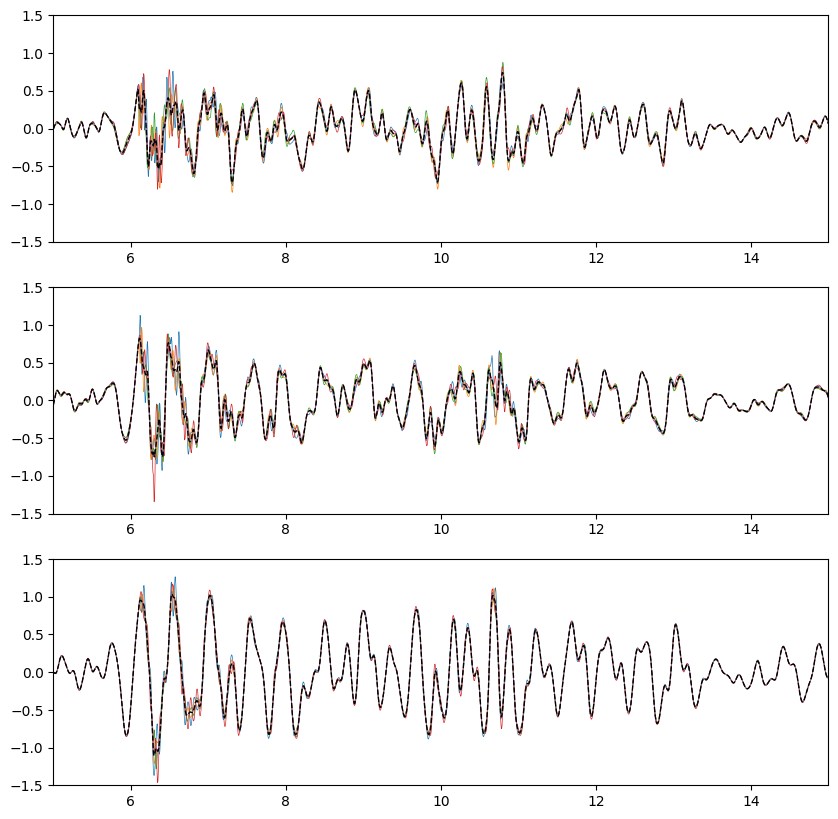

In [27]:
for model_tag, mr in model_responses.items():
    for record_tag, rr in mr.items():
        fig, axs = plt.subplots(3, 1, figsize=(10,10))
        for ii, (storey, storey_accs) in enumerate(rr["acc"].items()):
            for node, acc in storey_accs.items():
                axs[ii].plot(rr["time"], acc / 9810, lw=0.5)
            axs[ii].plot(rr["time"], storey_accs["mean"] / 9810, ls="--", color="k", lw=1.0)

for ax in axs:
    ax.set_xlim(5, 15)
    ax.set_ylim(-1.5, 1.5)

There are clearly instances where the nodes in each storey are being accelerated in different directions. This is not really realistic because in reality the slab (which is the majority of the mass) would all be accelerated in the same direction because it is more or less rigid (or can be assumed to be).

Perhaps a rigid diapraghm assumption is more applicable here... but then we wouldn't get any forces in our braces